# XXのデータ分析プログラム
本分析について、より正しく予測することおよびデータの構造についてや数理モデルの出力結果を明らかにするため、データ分析の手法としては
- データの読み込み
- 要約統計量
- 100通り学習ルールに基づいたのGBMを作成
- 100個の中で最も決定係数が高いモデルを使用
- SHAPを用いてモデルの解釈

を使用する。

## ライブラリのインポート
GBMにはLightGBMを使用する。理由としてはLightGBMに使われる勾配ブースティング回帰木は特性として標準化や正規化を行う必要が無く、後に因果関係を考察する上でも使用しやすいため。

In [1]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import shap

## データの読み込み

In [2]:
df = pd.read_csv("boston.csv")
df.head()

PRICE     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
0   24.0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1   21.6  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2   34.7  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3   33.4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4   36.2  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

## 目的変数の選択

In [3]:
y_col = "PRICE"

## 要約統計量の算出

In [4]:
df.describe()

PRICE        CRIM          ZN       INDUS        CHAS         NOX  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    22.532806    3.613524   11.363636   11.136779    0.069170    0.554695   
std      9.197104    8.601545   23.322453    6.860353    0.253994    0.115878   
min      5.000000    0.006320    0.000000    0.460000    0.000000    0.385000   
25%     17.025000    0.082045    0.000000    5.190000    0.000000    0.449000   
50%     21.200000    0.256510    0.000000    9.690000    0.000000    0.538000   
75%     25.000000    3.677083   12.500000   18.100000    0.000000    0.624000   
max     50.000000   88.976200  100.000000   27.740000    1.000000    0.871000   

               RM         AGE         DIS         RAD         TAX     PTRATIO  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     6.284634   68.574901    3.795043    9.549407  408.237154   18.455534   
std      0.702617   28.148861    2.105710    8.707259  168.537116    2.164946   
min      3.561000    2.900000    1.129600    1.000000  187.000000   12.600000   
25%      5.885500   45.025000    2.100175    4.000000  279.000000   17.400000   
50%      6.208500   77.500000    3.207450    5.000000  330.000000   19.050000   
75%      6.623500   94.075000    5.188425   24.000000  666.000000   20.200000   
max      8.780000  100.000000   12.126500   24.000000  711.000000   22.000000   

                B       LSTAT  
count  506.000000  506.000000  
mean   356.674032   12.653063  
std     91.294864    7.141062  
min      0.320000    1.730000  
25%    375.377500    6.950000  
50%    391.440000   11.360000  
75%    396.225000   16.955000  
max    396.900000   37.970000

## 相関行列の出力

In [5]:
df.corr()

PRICE      CRIM        ZN     INDUS      CHAS       NOX        RM  \
PRICE    1.000000 -0.388305  0.360445 -0.483725  0.175260 -0.427321  0.695360   
CRIM    -0.388305  1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247   
ZN       0.360445 -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991   
INDUS   -0.483725  0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676   
CHAS     0.175260 -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251   
NOX     -0.427321  0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188   
RM       0.695360 -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000   
AGE     -0.376955  0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265   
DIS      0.249929 -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246   
RAD     -0.381626  0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847   
TAX     -0.468536  0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048   
PTRATIO -0.507787  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501   
B        0.333461 -0.385064  0.175520 -0.356977  0.048788 -0.380051  0.128069   
LSTAT   -0.737663  0.455621 -0.412995  0.603800 -0.053929  0.590879 -0.613808   

              AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT  
PRICE   -0.376955  0.249929 -0.381626 -0.468536 -0.507787  0.333461 -0.737663  
CRIM     0.352734 -0.379670  0.625505  0.582764  0.289946 -0.385064  0.455621  
ZN      -0.569537  0.664408 -0.311948 -0.314563 -0.391679  0.175520 -0.412995  
INDUS    0.644779 -0.708027  0.595129  0.720760  0.383248 -0.356977  0.603800  
CHAS     0.086518 -0.099176 -0.007368 -0.035587 -0.121515  0.048788 -0.053929  
NOX      0.731470 -0.769230  0.611441  0.668023  0.188933 -0.380051  0.590879  
RM      -0.240265  0.205246 -0.209847 -0.292048 -0.355501  0.128069 -0.613808  
AGE      1.000000 -0.747881  0.456022  0.506456  0.261515 -0.273534  0.602339  
DIS     -0.747881  1.000000 -0.494588 -0.534432 -0.232471  0.291512 -0.496996  
RAD      0.456022 -0.494588  1.000000  0.910228  0.464741 -0.444413  0.488676  
TAX      0.506456 -0.534432  0.910228  1.000000  0.460853 -0.441808  0.543993  
PTRATIO  0.261515 -0.232471  0.464741  0.460853  1.000000 -0.177383  0.374044  
B       -0.273534  0.291512 -0.444413 -0.441808 -0.177383  1.000000 -0.366087  
LSTAT    0.602339 -0.496996  0.488676  0.543993  0.374044 -0.366087  1.000000

## VIFの計算
VIFは一般的に10を超えると多重共線性が確認できる。ここで前項の相関行列と照らし合わせて変数間の相互作用を考察する。

In [6]:
x = df.drop(y_col, axis=1)
inv = np.linalg.inv(x.corr().values)
vif = []
for i in range(len(inv)):
    vif.append(inv[i][i])
df_vif = pd.DataFrame(vif)
df_vif.index = x.corr().columns
df_vif.columns = ["VIF"]
df_vif

VIF
CRIM     1.792192
ZN       2.298758
INDUS    3.991596
CHAS     1.073995
NOX      4.393720
RM       1.933744
AGE      3.100826
DIS      3.955945
RAD      7.484496
TAX      9.008554
PTRATIO  1.799084
B        1.348521
LSTAT    2.941491

## 疑似相関の確認
データには見かけ上の相関が存在している可能性があるため、偏相関係数と用いて疑似相関が発生しているデータを見つける必要があり、何が原因で疑似相関が発生しているかを確認しておく必要がある。

In [7]:
def partcorr(r_xy, r_yz, r_xz):
    return (r_xy - r_yz * r_xz) / (np.sqrt(1 - r_xz ** 2) * np.sqrt(1 - r_yz ** 2))

In [8]:
pcorr = []
corr = x.corr()
for i in range(len(corr.columns)):
    for j in range(i, len(corr.columns)):
        for k in range(len(corr.columns)):
            if corr.columns[i] != corr.columns[k] and corr.columns[j] != corr.columns[k] and corr.columns[i] != corr.columns[j]:
                pcorr.append([corr.columns[i],
                              corr.columns[j],
                              corr.columns[k],
                              corr.at[corr.columns[i], corr.columns[j]],
                              partcorr(corr.at[corr.columns[i], corr.columns[j]],
                                       corr.at[corr.columns[j], corr.columns[k]],
                                       corr.at[corr.columns[k], corr.columns[i]]
                                      ),
                              abs(corr.at[corr.columns[i], corr.columns[j]]-partcorr(corr.at[corr.columns[i], corr.columns[j]], 
                                                                                     corr.at[corr.columns[j], corr.columns[k]], 
                                                                                     corr.at[corr.columns[k], corr.columns[i]])
                                 )])
columns = ["変数1", "変数2", "第三の因子", "相関係数", "偏相関係数", "偏相関係数と相関係数の差の絶対値"]
df_pcorr = pd.DataFrame(pcorr)
df_pcorr.columns = columns
df_pcorr.sort_values("偏相関係数と相関係数の差の絶対値", ascending=False)

変数1    変数2 第三の因子      相関係数     偏相関係数  偏相関係数と相関係数の差の絶対値
315  INDUS    RAD   TAX  0.595129 -0.212250          0.807379
502    NOX    RAD   TAX  0.611441  0.010991          0.600449
95    CRIM    TAX   RAD  0.582764  0.041511          0.541254
789    RAD  LSTAT   TAX  0.488676 -0.018654          0.507330
159     ZN    NOX   DIS -0.516604 -0.011561          0.505043
..     ...    ...   ...       ...       ...               ...
189     ZN    DIS  CHAS  0.664408  0.664050          0.000358
751    RAD    TAX  CHAS  0.910228  0.910567          0.000339
784    RAD  LSTAT  CHAS  0.488676  0.489004          0.000328
575     RM    RAD  CHAS -0.209847 -0.210056          0.000210
773    RAD      B  CHAS -0.444413 -0.444595          0.000182

[858 rows x 6 columns]

## ペアプロット

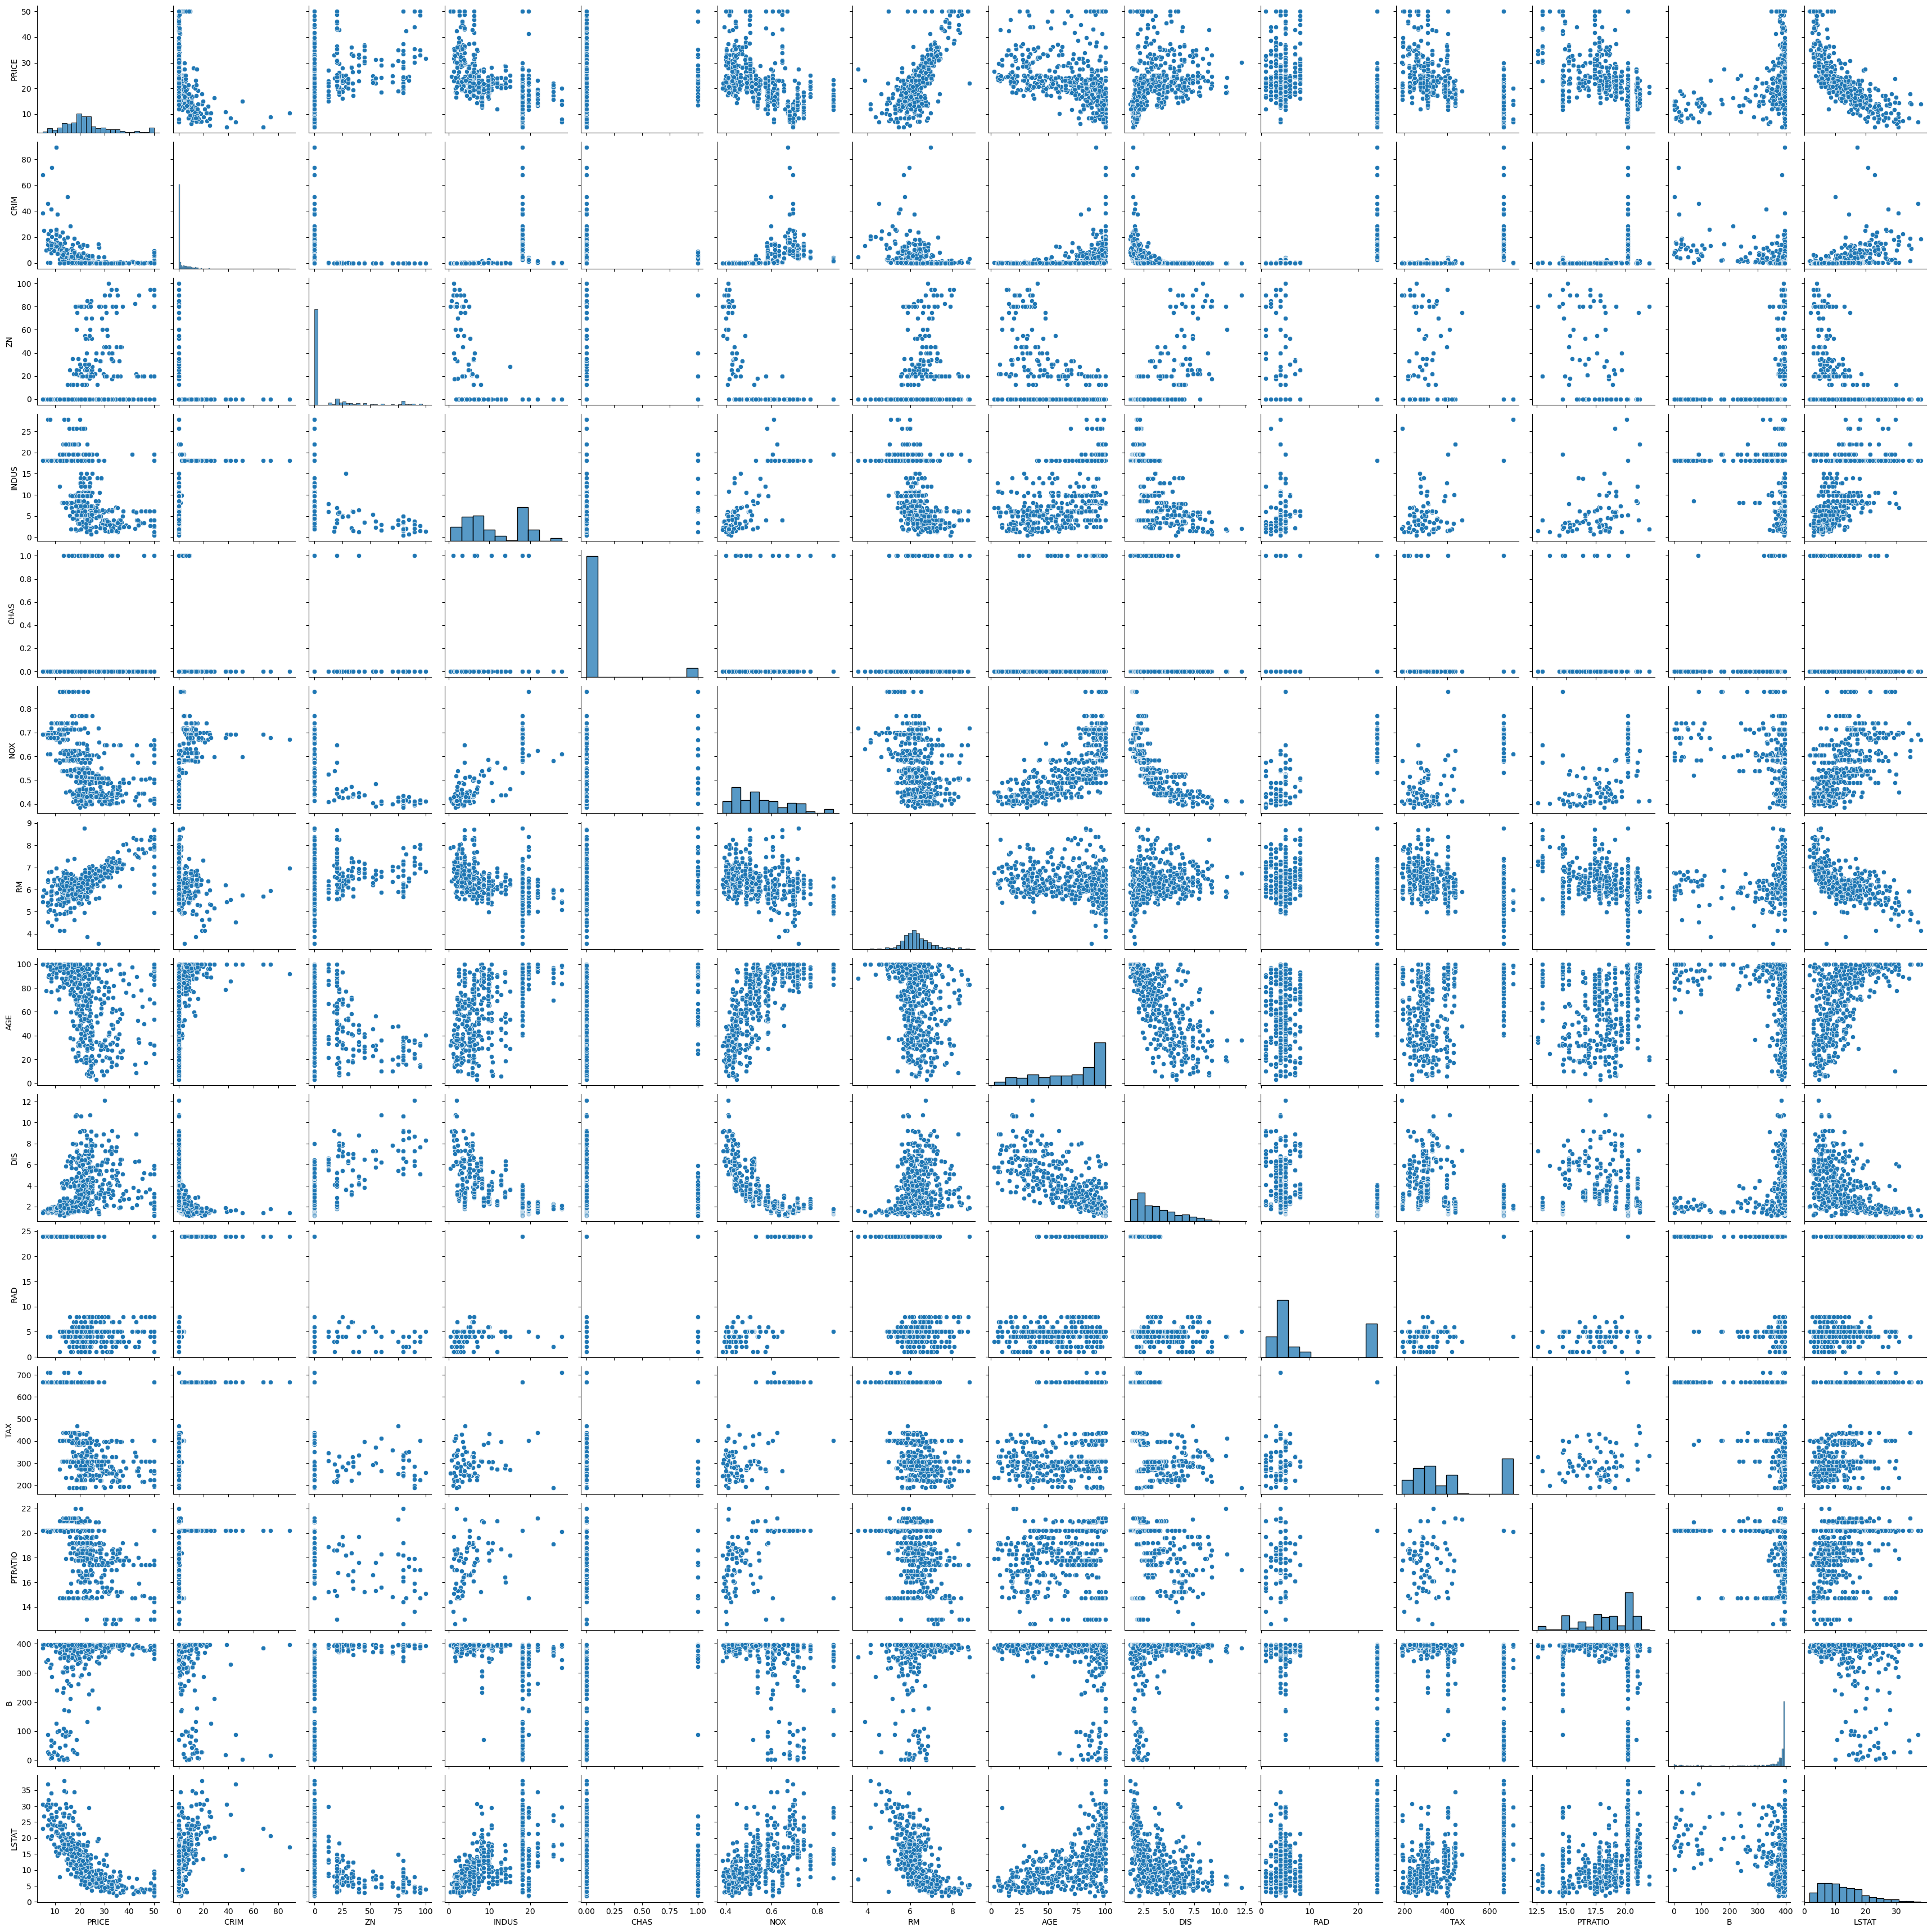

In [9]:
pg1 = sns.pairplot(df)
pg1

## ヒストグラム

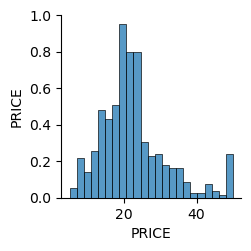

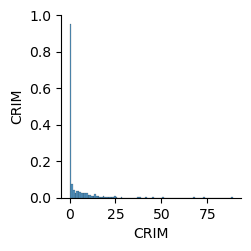

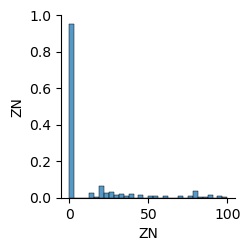

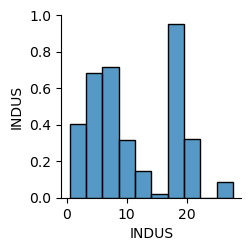

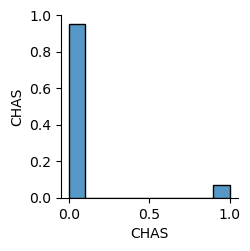

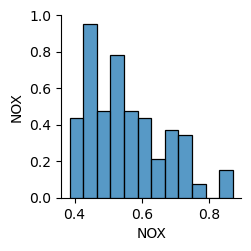

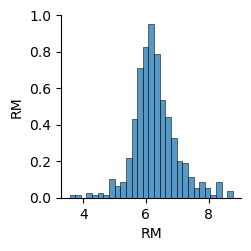

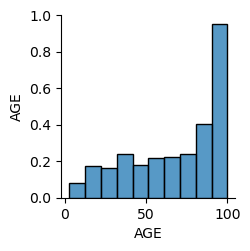

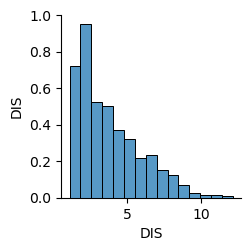

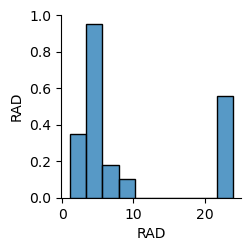

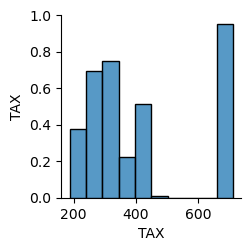

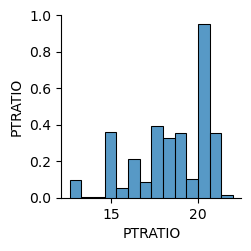

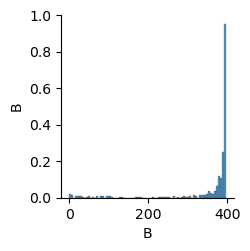

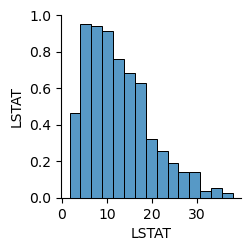

In [10]:
for col in df.columns:
    sns.pairplot(df, x_vars=[col], y_vars=[col])

## カーネル密度関数

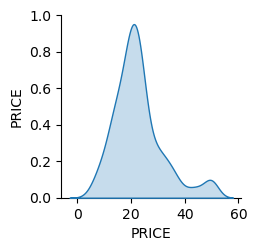

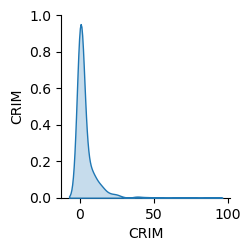

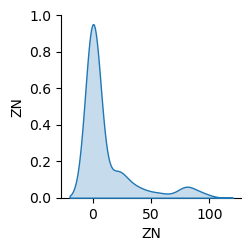

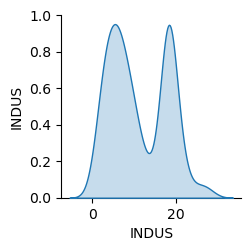

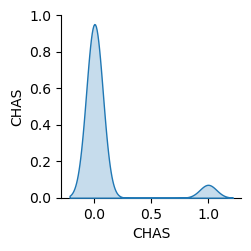

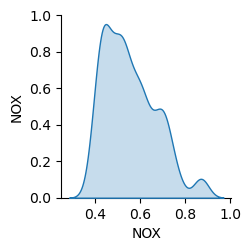

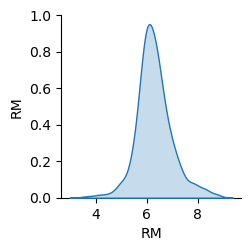

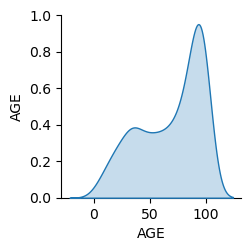

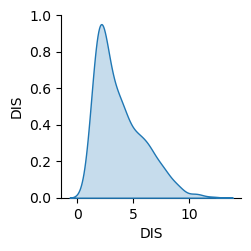

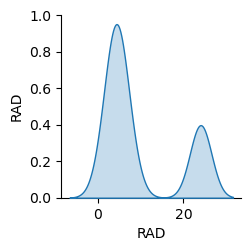

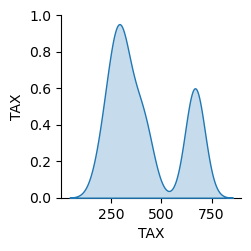

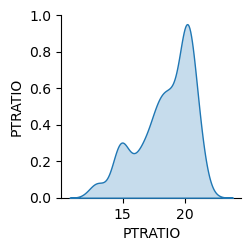

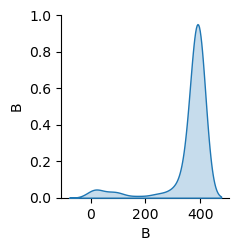

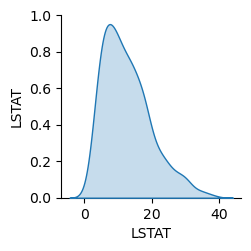

In [11]:
for col in df.columns:
    sns.pairplot(df, diag_kind="kde", x_vars=[col], y_vars=[col])

## 100通りの学習を別数理モデルの作成
### 目的変数を設定

### 説明変数と目的変数を分ける

In [12]:
y = df[y_col]
x = df.drop(y_col, axis=1)

### 100通りのモデルを格納するリストを宣言

In [13]:
models = []

### パラメータを設定

In [14]:
params = {"objective" : "regression",
          "metric" : "rmse",
          "boosting_type" : "gbdt",
          "verbosity" : -1
         }

### 100通りの学習方法によるモデルの作成
ここで100個のモデルを格納する時にモデルと決定係数をセットで格納する。

In [15]:
for i in range(100):
    x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=i)
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb.test = lgb.Dataset(x_test, y_test)
    model = lgb.train(params, lgb_train, valid_sets=lgb.test)
    optimum_boost_rounds = model.best_iteration
    y_pred = model.predict(x_test)
    models.append([model, r2_score(y_test, y_pred), x_train, y_train])

[1]	valid_0's rmse: 8.44062
[2]	valid_0's rmse: 7.91907
[3]	valid_0's rmse: 7.43478
[4]	valid_0's rmse: 7.02024
[5]	valid_0's rmse: 6.72933
[6]	valid_0's rmse: 6.43509
[7]	valid_0's rmse: 6.23152
[8]	valid_0's rmse: 6.00015
[9]	valid_0's rmse: 5.83123
[10]	valid_0's rmse: 5.70268
[11]	valid_0's rmse: 5.57368
[12]	valid_0's rmse: 5.47313
[13]	valid_0's rmse: 5.40386
[14]	valid_0's rmse: 5.36271
[15]	valid_0's rmse: 5.31535
[16]	valid_0's rmse: 5.29034
[17]	valid_0's rmse: 5.21882
[18]	valid_0's rmse: 5.21905
[19]	valid_0's rmse: 5.17156
[20]	valid_0's rmse: 5.16856
[21]	valid_0's rmse: 5.15432
[22]	valid_0's rmse: 5.13335
[23]	valid_0's rmse: 5.11036
[24]	valid_0's rmse: 5.10762
[25]	valid_0's rmse: 5.10286
[26]	valid_0's rmse: 5.08357
[27]	valid_0's rmse: 5.08271
[28]	valid_0's rmse: 5.07105
[29]	valid_0's rmse: 5.07118
[30]	valid_0's rmse: 5.06485
[31]	valid_0's rmse: 5.05695
[32]	valid_0's rmse: 5.04379
[33]	valid_0's rmse: 5.03949
[34]	valid_0's rmse: 5.04078
[35]	valid_0's rmse: 5.

[1]	valid_0's rmse: 8.99265
[2]	valid_0's rmse: 8.363
[3]	valid_0's rmse: 7.8185
[4]	valid_0's rmse: 7.3257
[5]	valid_0's rmse: 6.92887
[6]	valid_0's rmse: 6.57073
[7]	valid_0's rmse: 6.22148
[8]	valid_0's rmse: 5.91605
[9]	valid_0's rmse: 5.65098
[10]	valid_0's rmse: 5.43054
[11]	valid_0's rmse: 5.26676
[12]	valid_0's rmse: 5.08791
[13]	valid_0's rmse: 4.94476
[14]	valid_0's rmse: 4.77081
[15]	valid_0's rmse: 4.60711
[16]	valid_0's rmse: 4.49369
[17]	valid_0's rmse: 4.40297
[18]	valid_0's rmse: 4.29831
[19]	valid_0's rmse: 4.21382
[20]	valid_0's rmse: 4.13834
[21]	valid_0's rmse: 4.08182
[22]	valid_0's rmse: 4.01413
[23]	valid_0's rmse: 3.95603
[24]	valid_0's rmse: 3.91706
[25]	valid_0's rmse: 3.89357
[26]	valid_0's rmse: 3.86575
[27]	valid_0's rmse: 3.83853
[28]	valid_0's rmse: 3.82911
[29]	valid_0's rmse: 3.77472
[30]	valid_0's rmse: 3.74488
[31]	valid_0's rmse: 3.73468
[32]	valid_0's rmse: 3.71409
[33]	valid_0's rmse: 3.71401
[34]	valid_0's rmse: 3.69737
[35]	valid_0's rmse: 3.6855

[1]	valid_0's rmse: 7.92991
[2]	valid_0's rmse: 7.32223
[3]	valid_0's rmse: 6.79369
[4]	valid_0's rmse: 6.32599
[5]	valid_0's rmse: 5.9277
[6]	valid_0's rmse: 5.59169
[7]	valid_0's rmse: 5.33215
[8]	valid_0's rmse: 5.11068
[9]	valid_0's rmse: 4.93514
[10]	valid_0's rmse: 4.74259
[11]	valid_0's rmse: 4.59763
[12]	valid_0's rmse: 4.4796
[13]	valid_0's rmse: 4.38447
[14]	valid_0's rmse: 4.32689
[15]	valid_0's rmse: 4.25521
[16]	valid_0's rmse: 4.22357
[17]	valid_0's rmse: 4.20703
[18]	valid_0's rmse: 4.17656
[19]	valid_0's rmse: 4.17908
[20]	valid_0's rmse: 4.1333
[21]	valid_0's rmse: 4.12306
[22]	valid_0's rmse: 4.10556
[23]	valid_0's rmse: 4.08943
[24]	valid_0's rmse: 4.04529
[25]	valid_0's rmse: 4.02298
[26]	valid_0's rmse: 4.00764
[27]	valid_0's rmse: 4.01071
[28]	valid_0's rmse: 4.00423
[29]	valid_0's rmse: 4.00041
[30]	valid_0's rmse: 3.98231
[31]	valid_0's rmse: 3.98296
[32]	valid_0's rmse: 3.9642
[33]	valid_0's rmse: 3.9694
[34]	valid_0's rmse: 3.96115
[35]	valid_0's rmse: 3.95187

[67]	valid_0's rmse: 3.30905
[68]	valid_0's rmse: 3.30657
[69]	valid_0's rmse: 3.30156
[70]	valid_0's rmse: 3.29765
[71]	valid_0's rmse: 3.29864
[72]	valid_0's rmse: 3.30049
[73]	valid_0's rmse: 3.30494
[74]	valid_0's rmse: 3.30771
[75]	valid_0's rmse: 3.30651
[76]	valid_0's rmse: 3.30232
[77]	valid_0's rmse: 3.30276
[78]	valid_0's rmse: 3.31052
[79]	valid_0's rmse: 3.30734
[80]	valid_0's rmse: 3.29794
[81]	valid_0's rmse: 3.29385
[82]	valid_0's rmse: 3.30389
[83]	valid_0's rmse: 3.29768
[84]	valid_0's rmse: 3.29293
[85]	valid_0's rmse: 3.29965
[86]	valid_0's rmse: 3.29549
[87]	valid_0's rmse: 3.30234
[88]	valid_0's rmse: 3.29658
[89]	valid_0's rmse: 3.28857
[90]	valid_0's rmse: 3.28867
[91]	valid_0's rmse: 3.27868
[92]	valid_0's rmse: 3.27358
[93]	valid_0's rmse: 3.28207
[94]	valid_0's rmse: 3.27823
[95]	valid_0's rmse: 3.28088
[96]	valid_0's rmse: 3.27308
[97]	valid_0's rmse: 3.26758
[98]	valid_0's rmse: 3.26842
[99]	valid_0's rmse: 3.26826
[100]	valid_0's rmse: 3.26449
[1]	valid_0's

[1]	valid_0's rmse: 7.55916
[2]	valid_0's rmse: 7.00025
[3]	valid_0's rmse: 6.52943
[4]	valid_0's rmse: 6.10457
[5]	valid_0's rmse: 5.77758
[6]	valid_0's rmse: 5.46918
[7]	valid_0's rmse: 5.21308
[8]	valid_0's rmse: 5.00316
[9]	valid_0's rmse: 4.84531
[10]	valid_0's rmse: 4.69617
[11]	valid_0's rmse: 4.58543
[12]	valid_0's rmse: 4.47137
[13]	valid_0's rmse: 4.36998
[14]	valid_0's rmse: 4.27643
[15]	valid_0's rmse: 4.19835
[16]	valid_0's rmse: 4.11496
[17]	valid_0's rmse: 4.06164
[18]	valid_0's rmse: 3.97053
[19]	valid_0's rmse: 3.92968
[20]	valid_0's rmse: 3.9051
[21]	valid_0's rmse: 3.87555
[22]	valid_0's rmse: 3.86124
[23]	valid_0's rmse: 3.81708
[24]	valid_0's rmse: 3.77524
[25]	valid_0's rmse: 3.73876
[26]	valid_0's rmse: 3.72736
[27]	valid_0's rmse: 3.6901
[28]	valid_0's rmse: 3.65874
[29]	valid_0's rmse: 3.63856
[30]	valid_0's rmse: 3.6244
[31]	valid_0's rmse: 3.60199
[32]	valid_0's rmse: 3.5819
[33]	valid_0's rmse: 3.55275
[34]	valid_0's rmse: 3.5324
[35]	valid_0's rmse: 3.53401

[95]	valid_0's rmse: 3.39589
[96]	valid_0's rmse: 3.40426
[97]	valid_0's rmse: 3.40558
[98]	valid_0's rmse: 3.40419
[99]	valid_0's rmse: 3.40209
[100]	valid_0's rmse: 3.39995
[1]	valid_0's rmse: 9.02459
[2]	valid_0's rmse: 8.42786
[3]	valid_0's rmse: 7.88556
[4]	valid_0's rmse: 7.42043
[5]	valid_0's rmse: 6.9847
[6]	valid_0's rmse: 6.61549
[7]	valid_0's rmse: 6.27499
[8]	valid_0's rmse: 5.95495
[9]	valid_0's rmse: 5.68813
[10]	valid_0's rmse: 5.45336
[11]	valid_0's rmse: 5.27802
[12]	valid_0's rmse: 5.11043
[13]	valid_0's rmse: 4.966
[14]	valid_0's rmse: 4.852
[15]	valid_0's rmse: 4.73699
[16]	valid_0's rmse: 4.60613
[17]	valid_0's rmse: 4.5318
[18]	valid_0's rmse: 4.47958
[19]	valid_0's rmse: 4.39751
[20]	valid_0's rmse: 4.30931
[21]	valid_0's rmse: 4.26049
[22]	valid_0's rmse: 4.21424
[23]	valid_0's rmse: 4.18469
[24]	valid_0's rmse: 4.12939
[25]	valid_0's rmse: 4.10498
[26]	valid_0's rmse: 4.05484
[27]	valid_0's rmse: 4.02553
[28]	valid_0's rmse: 4.00348
[29]	valid_0's rmse: 3.97583

[99]	valid_0's rmse: 3.66658
[100]	valid_0's rmse: 3.66281
[1]	valid_0's rmse: 7.74913
[2]	valid_0's rmse: 7.28671
[3]	valid_0's rmse: 6.86286
[4]	valid_0's rmse: 6.50488
[5]	valid_0's rmse: 6.20489
[6]	valid_0's rmse: 5.94209
[7]	valid_0's rmse: 5.73287
[8]	valid_0's rmse: 5.54043
[9]	valid_0's rmse: 5.37676
[10]	valid_0's rmse: 5.24953
[11]	valid_0's rmse: 5.12579
[12]	valid_0's rmse: 5.04257
[13]	valid_0's rmse: 4.92624
[14]	valid_0's rmse: 4.83512
[15]	valid_0's rmse: 4.74655
[16]	valid_0's rmse: 4.69819
[17]	valid_0's rmse: 4.62913
[18]	valid_0's rmse: 4.57106
[19]	valid_0's rmse: 4.52737
[20]	valid_0's rmse: 4.50516
[21]	valid_0's rmse: 4.45126
[22]	valid_0's rmse: 4.40382
[23]	valid_0's rmse: 4.37916
[24]	valid_0's rmse: 4.28781
[25]	valid_0's rmse: 4.26688
[26]	valid_0's rmse: 4.25392
[27]	valid_0's rmse: 4.23645
[28]	valid_0's rmse: 4.22196
[29]	valid_0's rmse: 4.1987
[30]	valid_0's rmse: 4.19399
[31]	valid_0's rmse: 4.18775
[32]	valid_0's rmse: 4.17902
[33]	valid_0's rmse: 4.

[1]	valid_0's rmse: 8.03398
[2]	valid_0's rmse: 7.43835
[3]	valid_0's rmse: 6.91019
[4]	valid_0's rmse: 6.39578
[5]	valid_0's rmse: 5.99241
[6]	valid_0's rmse: 5.61197
[7]	valid_0's rmse: 5.28629
[8]	valid_0's rmse: 5.02955
[9]	valid_0's rmse: 4.80738
[10]	valid_0's rmse: 4.61812
[11]	valid_0's rmse: 4.46072
[12]	valid_0's rmse: 4.29207
[13]	valid_0's rmse: 4.17115
[14]	valid_0's rmse: 4.04198
[15]	valid_0's rmse: 3.90982
[16]	valid_0's rmse: 3.80533
[17]	valid_0's rmse: 3.7148
[18]	valid_0's rmse: 3.63308
[19]	valid_0's rmse: 3.59257
[20]	valid_0's rmse: 3.52967
[21]	valid_0's rmse: 3.51523
[22]	valid_0's rmse: 3.47759
[23]	valid_0's rmse: 3.42167
[24]	valid_0's rmse: 3.40389
[25]	valid_0's rmse: 3.39297
[26]	valid_0's rmse: 3.34947
[27]	valid_0's rmse: 3.31693
[28]	valid_0's rmse: 3.30764
[29]	valid_0's rmse: 3.28059
[30]	valid_0's rmse: 3.27484
[31]	valid_0's rmse: 3.25469
[32]	valid_0's rmse: 3.25301
[33]	valid_0's rmse: 3.22317
[34]	valid_0's rmse: 3.21199
[35]	valid_0's rmse: 3.2

[1]	valid_0's rmse: 7.88022
[2]	valid_0's rmse: 7.27073
[3]	valid_0's rmse: 6.73438
[4]	valid_0's rmse: 6.27344
[5]	valid_0's rmse: 5.85551
[6]	valid_0's rmse: 5.52406
[7]	valid_0's rmse: 5.22894
[8]	valid_0's rmse: 4.97915
[9]	valid_0's rmse: 4.79484
[10]	valid_0's rmse: 4.59142
[11]	valid_0's rmse: 4.45799
[12]	valid_0's rmse: 4.32587
[13]	valid_0's rmse: 4.22742
[14]	valid_0's rmse: 4.13676
[15]	valid_0's rmse: 4.08023
[16]	valid_0's rmse: 4.04102
[17]	valid_0's rmse: 4.02547
[18]	valid_0's rmse: 4.01193
[19]	valid_0's rmse: 3.94108
[20]	valid_0's rmse: 3.90429
[21]	valid_0's rmse: 3.87299
[22]	valid_0's rmse: 3.83107
[23]	valid_0's rmse: 3.80978
[24]	valid_0's rmse: 3.8116
[25]	valid_0's rmse: 3.79507
[26]	valid_0's rmse: 3.79178
[27]	valid_0's rmse: 3.76261
[28]	valid_0's rmse: 3.76212
[29]	valid_0's rmse: 3.74858
[30]	valid_0's rmse: 3.74115
[31]	valid_0's rmse: 3.72016
[32]	valid_0's rmse: 3.72383
[33]	valid_0's rmse: 3.70821
[34]	valid_0's rmse: 3.68837
[35]	valid_0's rmse: 3.6

[23]	valid_0's rmse: 5.17283
[24]	valid_0's rmse: 5.10531
[25]	valid_0's rmse: 5.04388
[26]	valid_0's rmse: 4.99312
[27]	valid_0's rmse: 4.95046
[28]	valid_0's rmse: 4.89044
[29]	valid_0's rmse: 4.86182
[30]	valid_0's rmse: 4.82617
[31]	valid_0's rmse: 4.7799
[32]	valid_0's rmse: 4.75764
[33]	valid_0's rmse: 4.70679
[34]	valid_0's rmse: 4.66313
[35]	valid_0's rmse: 4.64266
[36]	valid_0's rmse: 4.60728
[37]	valid_0's rmse: 4.57773
[38]	valid_0's rmse: 4.56087
[39]	valid_0's rmse: 4.53168
[40]	valid_0's rmse: 4.51831
[41]	valid_0's rmse: 4.49192
[42]	valid_0's rmse: 4.48642
[43]	valid_0's rmse: 4.46505
[44]	valid_0's rmse: 4.45875
[45]	valid_0's rmse: 4.44231
[46]	valid_0's rmse: 4.4365
[47]	valid_0's rmse: 4.4177
[48]	valid_0's rmse: 4.42236
[49]	valid_0's rmse: 4.4084
[50]	valid_0's rmse: 4.3961
[51]	valid_0's rmse: 4.36022
[52]	valid_0's rmse: 4.3361
[53]	valid_0's rmse: 4.34184
[54]	valid_0's rmse: 4.33443
[55]	valid_0's rmse: 4.3233
[56]	valid_0's rmse: 4.31406
[57]	valid_0's rmse: 

[44]	valid_0's rmse: 4.25673
[45]	valid_0's rmse: 4.25688
[46]	valid_0's rmse: 4.26698
[47]	valid_0's rmse: 4.27382
[48]	valid_0's rmse: 4.28458
[49]	valid_0's rmse: 4.2827
[50]	valid_0's rmse: 4.29106
[51]	valid_0's rmse: 4.31173
[52]	valid_0's rmse: 4.31117
[53]	valid_0's rmse: 4.31194
[54]	valid_0's rmse: 4.31792
[55]	valid_0's rmse: 4.3148
[56]	valid_0's rmse: 4.30828
[57]	valid_0's rmse: 4.30971
[58]	valid_0's rmse: 4.31248
[59]	valid_0's rmse: 4.31086
[60]	valid_0's rmse: 4.31698
[61]	valid_0's rmse: 4.32723
[62]	valid_0's rmse: 4.34358
[63]	valid_0's rmse: 4.34675
[64]	valid_0's rmse: 4.35399
[65]	valid_0's rmse: 4.34596
[66]	valid_0's rmse: 4.34941
[67]	valid_0's rmse: 4.35999
[68]	valid_0's rmse: 4.36469
[69]	valid_0's rmse: 4.36048
[70]	valid_0's rmse: 4.3704
[71]	valid_0's rmse: 4.38254
[72]	valid_0's rmse: 4.3818
[73]	valid_0's rmse: 4.37575
[74]	valid_0's rmse: 4.37339
[75]	valid_0's rmse: 4.38119
[76]	valid_0's rmse: 4.38606
[77]	valid_0's rmse: 4.38862
[78]	valid_0's rms

[11]	valid_0's rmse: 5.00047
[12]	valid_0's rmse: 4.79756
[13]	valid_0's rmse: 4.61604
[14]	valid_0's rmse: 4.46848
[15]	valid_0's rmse: 4.31511
[16]	valid_0's rmse: 4.21725
[17]	valid_0's rmse: 4.11161
[18]	valid_0's rmse: 4.00566
[19]	valid_0's rmse: 3.88976
[20]	valid_0's rmse: 3.78783
[21]	valid_0's rmse: 3.71499
[22]	valid_0's rmse: 3.63443
[23]	valid_0's rmse: 3.57027
[24]	valid_0's rmse: 3.52982
[25]	valid_0's rmse: 3.48414
[26]	valid_0's rmse: 3.44716
[27]	valid_0's rmse: 3.42498
[28]	valid_0's rmse: 3.39192
[29]	valid_0's rmse: 3.38173
[30]	valid_0's rmse: 3.34961
[31]	valid_0's rmse: 3.32777
[32]	valid_0's rmse: 3.30598
[33]	valid_0's rmse: 3.29966
[34]	valid_0's rmse: 3.28268
[35]	valid_0's rmse: 3.26685
[36]	valid_0's rmse: 3.26003
[37]	valid_0's rmse: 3.24885
[38]	valid_0's rmse: 3.22904
[39]	valid_0's rmse: 3.21491
[40]	valid_0's rmse: 3.19805
[41]	valid_0's rmse: 3.19901
[42]	valid_0's rmse: 3.19765
[43]	valid_0's rmse: 3.1877
[44]	valid_0's rmse: 3.18871
[45]	valid_0's 

[1]	valid_0's rmse: 9.10961
[2]	valid_0's rmse: 8.42921
[3]	valid_0's rmse: 7.83198
[4]	valid_0's rmse: 7.34176
[5]	valid_0's rmse: 6.87819
[6]	valid_0's rmse: 6.47169
[7]	valid_0's rmse: 6.13086
[8]	valid_0's rmse: 5.84155
[9]	valid_0's rmse: 5.6166
[10]	valid_0's rmse: 5.41505
[11]	valid_0's rmse: 5.23033
[12]	valid_0's rmse: 5.07032
[13]	valid_0's rmse: 4.92174
[14]	valid_0's rmse: 4.80481
[15]	valid_0's rmse: 4.70215
[16]	valid_0's rmse: 4.60538
[17]	valid_0's rmse: 4.50893
[18]	valid_0's rmse: 4.42315
[19]	valid_0's rmse: 4.37061
[20]	valid_0's rmse: 4.31569
[21]	valid_0's rmse: 4.27592
[22]	valid_0's rmse: 4.23079
[23]	valid_0's rmse: 4.20631
[24]	valid_0's rmse: 4.17802
[25]	valid_0's rmse: 4.16068
[26]	valid_0's rmse: 4.14089
[27]	valid_0's rmse: 4.12069
[28]	valid_0's rmse: 4.11228
[29]	valid_0's rmse: 4.08504
[30]	valid_0's rmse: 4.06297
[31]	valid_0's rmse: 4.04038
[32]	valid_0's rmse: 4.01176
[33]	valid_0's rmse: 3.98637
[34]	valid_0's rmse: 3.97119
[35]	valid_0's rmse: 3.9

[24]	valid_0's rmse: 4.13931
[25]	valid_0's rmse: 4.10978
[26]	valid_0's rmse: 4.07705
[27]	valid_0's rmse: 4.05205
[28]	valid_0's rmse: 4.02526
[29]	valid_0's rmse: 3.97741
[30]	valid_0's rmse: 3.95187
[31]	valid_0's rmse: 3.90889
[32]	valid_0's rmse: 3.88735
[33]	valid_0's rmse: 3.87505
[34]	valid_0's rmse: 3.85586
[35]	valid_0's rmse: 3.84637
[36]	valid_0's rmse: 3.83349
[37]	valid_0's rmse: 3.83466
[38]	valid_0's rmse: 3.84059
[39]	valid_0's rmse: 3.8336
[40]	valid_0's rmse: 3.83343
[41]	valid_0's rmse: 3.83115
[42]	valid_0's rmse: 3.81803
[43]	valid_0's rmse: 3.79392
[44]	valid_0's rmse: 3.79136
[45]	valid_0's rmse: 3.75909
[46]	valid_0's rmse: 3.75579
[47]	valid_0's rmse: 3.74725
[48]	valid_0's rmse: 3.74013
[49]	valid_0's rmse: 3.73919
[50]	valid_0's rmse: 3.7343
[51]	valid_0's rmse: 3.73883
[52]	valid_0's rmse: 3.72865
[53]	valid_0's rmse: 3.71465
[54]	valid_0's rmse: 3.70855
[55]	valid_0's rmse: 3.71543
[56]	valid_0's rmse: 3.69489
[57]	valid_0's rmse: 3.69072
[58]	valid_0's r

[35]	valid_0's rmse: 4.47332
[36]	valid_0's rmse: 4.46971
[37]	valid_0's rmse: 4.44886
[38]	valid_0's rmse: 4.41473
[39]	valid_0's rmse: 4.41929
[40]	valid_0's rmse: 4.40989
[41]	valid_0's rmse: 4.38945
[42]	valid_0's rmse: 4.37603
[43]	valid_0's rmse: 4.36091
[44]	valid_0's rmse: 4.34903
[45]	valid_0's rmse: 4.3492
[46]	valid_0's rmse: 4.34684
[47]	valid_0's rmse: 4.33679
[48]	valid_0's rmse: 4.31789
[49]	valid_0's rmse: 4.31124
[50]	valid_0's rmse: 4.29266
[51]	valid_0's rmse: 4.28336
[52]	valid_0's rmse: 4.29387
[53]	valid_0's rmse: 4.29241
[54]	valid_0's rmse: 4.27657
[55]	valid_0's rmse: 4.26925
[56]	valid_0's rmse: 4.25488
[57]	valid_0's rmse: 4.24649
[58]	valid_0's rmse: 4.24139
[59]	valid_0's rmse: 4.22825
[60]	valid_0's rmse: 4.22266
[61]	valid_0's rmse: 4.21857
[62]	valid_0's rmse: 4.20249
[63]	valid_0's rmse: 4.1977
[64]	valid_0's rmse: 4.19427
[65]	valid_0's rmse: 4.19808
[66]	valid_0's rmse: 4.18973
[67]	valid_0's rmse: 4.19464
[68]	valid_0's rmse: 4.18759
[69]	valid_0's r

[88]	valid_0's rmse: 3.32545
[89]	valid_0's rmse: 3.31846
[90]	valid_0's rmse: 3.31189
[91]	valid_0's rmse: 3.31454
[92]	valid_0's rmse: 3.30548
[93]	valid_0's rmse: 3.30377
[94]	valid_0's rmse: 3.30581
[95]	valid_0's rmse: 3.30166
[96]	valid_0's rmse: 3.30392
[97]	valid_0's rmse: 3.30801
[98]	valid_0's rmse: 3.30348
[99]	valid_0's rmse: 3.30001
[100]	valid_0's rmse: 3.296
[1]	valid_0's rmse: 9.79518
[2]	valid_0's rmse: 9.09259
[3]	valid_0's rmse: 8.46507
[4]	valid_0's rmse: 7.90659
[5]	valid_0's rmse: 7.44271
[6]	valid_0's rmse: 7.00855
[7]	valid_0's rmse: 6.62092
[8]	valid_0's rmse: 6.26607
[9]	valid_0's rmse: 5.97188
[10]	valid_0's rmse: 5.70932
[11]	valid_0's rmse: 5.47365
[12]	valid_0's rmse: 5.27542
[13]	valid_0's rmse: 5.09013
[14]	valid_0's rmse: 4.90678
[15]	valid_0's rmse: 4.73441
[16]	valid_0's rmse: 4.59801
[17]	valid_0's rmse: 4.48884
[18]	valid_0's rmse: 4.38981
[19]	valid_0's rmse: 4.29481
[20]	valid_0's rmse: 4.23448
[21]	valid_0's rmse: 4.16834
[22]	valid_0's rmse: 4.1

[1]	valid_0's rmse: 9.06205
[2]	valid_0's rmse: 8.60432
[3]	valid_0's rmse: 8.2045
[4]	valid_0's rmse: 7.85697
[5]	valid_0's rmse: 7.55567
[6]	valid_0's rmse: 7.29747
[7]	valid_0's rmse: 7.07497
[8]	valid_0's rmse: 6.88508
[9]	valid_0's rmse: 6.72929
[10]	valid_0's rmse: 6.57193
[11]	valid_0's rmse: 6.42199
[12]	valid_0's rmse: 6.24085
[13]	valid_0's rmse: 6.12493
[14]	valid_0's rmse: 6.01265
[15]	valid_0's rmse: 5.91705
[16]	valid_0's rmse: 5.83445
[17]	valid_0's rmse: 5.74127
[18]	valid_0's rmse: 5.68652
[19]	valid_0's rmse: 5.60864
[20]	valid_0's rmse: 5.56589
[21]	valid_0's rmse: 5.51939
[22]	valid_0's rmse: 5.45696
[23]	valid_0's rmse: 5.36498
[24]	valid_0's rmse: 5.31465
[25]	valid_0's rmse: 5.25138
[26]	valid_0's rmse: 5.20363
[27]	valid_0's rmse: 5.16263
[28]	valid_0's rmse: 5.14016
[29]	valid_0's rmse: 5.10638
[30]	valid_0's rmse: 5.06075
[31]	valid_0's rmse: 5.03526
[32]	valid_0's rmse: 5.00329
[33]	valid_0's rmse: 4.98381
[34]	valid_0's rmse: 4.96977
[35]	valid_0's rmse: 4.9

[58]	valid_0's rmse: 3.64031
[59]	valid_0's rmse: 3.62845
[60]	valid_0's rmse: 3.61154
[61]	valid_0's rmse: 3.60425
[62]	valid_0's rmse: 3.59825
[63]	valid_0's rmse: 3.5803
[64]	valid_0's rmse: 3.58441
[65]	valid_0's rmse: 3.58249
[66]	valid_0's rmse: 3.58006
[67]	valid_0's rmse: 3.57926
[68]	valid_0's rmse: 3.57307
[69]	valid_0's rmse: 3.56239
[70]	valid_0's rmse: 3.56729
[71]	valid_0's rmse: 3.54299
[72]	valid_0's rmse: 3.52102
[73]	valid_0's rmse: 3.50489
[74]	valid_0's rmse: 3.50312
[75]	valid_0's rmse: 3.50488
[76]	valid_0's rmse: 3.49034
[77]	valid_0's rmse: 3.49024
[78]	valid_0's rmse: 3.49027
[79]	valid_0's rmse: 3.48985
[80]	valid_0's rmse: 3.48097
[81]	valid_0's rmse: 3.46411
[82]	valid_0's rmse: 3.46504
[83]	valid_0's rmse: 3.44705
[84]	valid_0's rmse: 3.44399
[85]	valid_0's rmse: 3.44699
[86]	valid_0's rmse: 3.44204
[87]	valid_0's rmse: 3.44343
[88]	valid_0's rmse: 3.44108
[89]	valid_0's rmse: 3.44128
[90]	valid_0's rmse: 3.43897
[91]	valid_0's rmse: 3.44194
[92]	valid_0's 

[34]	valid_0's rmse: 3.43177
[35]	valid_0's rmse: 3.41647
[36]	valid_0's rmse: 3.40428
[37]	valid_0's rmse: 3.42948
[38]	valid_0's rmse: 3.4221
[39]	valid_0's rmse: 3.4066
[40]	valid_0's rmse: 3.38334
[41]	valid_0's rmse: 3.36797
[42]	valid_0's rmse: 3.35292
[43]	valid_0's rmse: 3.34995
[44]	valid_0's rmse: 3.36914
[45]	valid_0's rmse: 3.37488
[46]	valid_0's rmse: 3.37468
[47]	valid_0's rmse: 3.37951
[48]	valid_0's rmse: 3.37582
[49]	valid_0's rmse: 3.38239
[50]	valid_0's rmse: 3.38338
[51]	valid_0's rmse: 3.37029
[52]	valid_0's rmse: 3.37786
[53]	valid_0's rmse: 3.37082
[54]	valid_0's rmse: 3.39184
[55]	valid_0's rmse: 3.39244
[56]	valid_0's rmse: 3.39546
[57]	valid_0's rmse: 3.40114
[58]	valid_0's rmse: 3.38563
[59]	valid_0's rmse: 3.38833
[60]	valid_0's rmse: 3.3894
[61]	valid_0's rmse: 3.40489
[62]	valid_0's rmse: 3.40404
[63]	valid_0's rmse: 3.40365
[64]	valid_0's rmse: 3.39494
[65]	valid_0's rmse: 3.4122
[66]	valid_0's rmse: 3.41488
[67]	valid_0's rmse: 3.40094
[68]	valid_0's rms

[95]	valid_0's rmse: 2.9727
[96]	valid_0's rmse: 2.96827
[97]	valid_0's rmse: 2.96549
[98]	valid_0's rmse: 2.97108
[99]	valid_0's rmse: 2.97338
[100]	valid_0's rmse: 2.98138
[1]	valid_0's rmse: 7.80325
[2]	valid_0's rmse: 7.16299
[3]	valid_0's rmse: 6.6063
[4]	valid_0's rmse: 6.14688
[5]	valid_0's rmse: 5.76903
[6]	valid_0's rmse: 5.44498
[7]	valid_0's rmse: 5.09079
[8]	valid_0's rmse: 4.78497
[9]	valid_0's rmse: 4.54471
[10]	valid_0's rmse: 4.31643
[11]	valid_0's rmse: 4.10778
[12]	valid_0's rmse: 3.92341
[13]	valid_0's rmse: 3.76864
[14]	valid_0's rmse: 3.66247
[15]	valid_0's rmse: 3.5177
[16]	valid_0's rmse: 3.42467
[17]	valid_0's rmse: 3.334
[18]	valid_0's rmse: 3.27149
[19]	valid_0's rmse: 3.21815
[20]	valid_0's rmse: 3.15258
[21]	valid_0's rmse: 3.13284
[22]	valid_0's rmse: 3.09647
[23]	valid_0's rmse: 3.03897
[24]	valid_0's rmse: 3.01324
[25]	valid_0's rmse: 2.9958
[26]	valid_0's rmse: 2.96784
[27]	valid_0's rmse: 2.95978
[28]	valid_0's rmse: 2.96178
[29]	valid_0's rmse: 2.92088

[64]	valid_0's rmse: 2.82088
[65]	valid_0's rmse: 2.82352
[66]	valid_0's rmse: 2.83004
[67]	valid_0's rmse: 2.82403
[68]	valid_0's rmse: 2.8243
[69]	valid_0's rmse: 2.82355
[70]	valid_0's rmse: 2.82237
[71]	valid_0's rmse: 2.817
[72]	valid_0's rmse: 2.81038
[73]	valid_0's rmse: 2.81785
[74]	valid_0's rmse: 2.80587
[75]	valid_0's rmse: 2.80053
[76]	valid_0's rmse: 2.80121
[77]	valid_0's rmse: 2.80621
[78]	valid_0's rmse: 2.80413
[79]	valid_0's rmse: 2.80585
[80]	valid_0's rmse: 2.80437
[81]	valid_0's rmse: 2.80345
[82]	valid_0's rmse: 2.80352
[83]	valid_0's rmse: 2.81151
[84]	valid_0's rmse: 2.8142
[85]	valid_0's rmse: 2.81135
[86]	valid_0's rmse: 2.8051
[87]	valid_0's rmse: 2.80219
[88]	valid_0's rmse: 2.80267
[89]	valid_0's rmse: 2.80318
[90]	valid_0's rmse: 2.80421
[91]	valid_0's rmse: 2.8056
[92]	valid_0's rmse: 2.81185
[93]	valid_0's rmse: 2.81486
[94]	valid_0's rmse: 2.8061
[95]	valid_0's rmse: 2.8119
[96]	valid_0's rmse: 2.81696
[97]	valid_0's rmse: 2.82088
[98]	valid_0's rmse: 2

[23]	valid_0's rmse: 3.16823
[24]	valid_0's rmse: 3.12514
[25]	valid_0's rmse: 3.08636
[26]	valid_0's rmse: 3.05354
[27]	valid_0's rmse: 3.06371
[28]	valid_0's rmse: 3.04488
[29]	valid_0's rmse: 2.99627
[30]	valid_0's rmse: 2.98698
[31]	valid_0's rmse: 2.96295
[32]	valid_0's rmse: 2.95935
[33]	valid_0's rmse: 2.95433
[34]	valid_0's rmse: 2.93738
[35]	valid_0's rmse: 2.91889
[36]	valid_0's rmse: 2.92257
[37]	valid_0's rmse: 2.93259
[38]	valid_0's rmse: 2.93338
[39]	valid_0's rmse: 2.92552
[40]	valid_0's rmse: 2.9264
[41]	valid_0's rmse: 2.92315
[42]	valid_0's rmse: 2.92324
[43]	valid_0's rmse: 2.91797
[44]	valid_0's rmse: 2.90851
[45]	valid_0's rmse: 2.92477
[46]	valid_0's rmse: 2.93882
[47]	valid_0's rmse: 2.93072
[48]	valid_0's rmse: 2.93567
[49]	valid_0's rmse: 2.93155
[50]	valid_0's rmse: 2.92512
[51]	valid_0's rmse: 2.92511
[52]	valid_0's rmse: 2.93091
[53]	valid_0's rmse: 2.92248
[54]	valid_0's rmse: 2.91827
[55]	valid_0's rmse: 2.93184
[56]	valid_0's rmse: 2.93571
[57]	valid_0's 

[14]	valid_0's rmse: 4.67204
[15]	valid_0's rmse: 4.58185
[16]	valid_0's rmse: 4.4495
[17]	valid_0's rmse: 4.39415
[18]	valid_0's rmse: 4.33876
[19]	valid_0's rmse: 4.27152
[20]	valid_0's rmse: 4.20849
[21]	valid_0's rmse: 4.16127
[22]	valid_0's rmse: 4.12238
[23]	valid_0's rmse: 4.07062
[24]	valid_0's rmse: 4.0499
[25]	valid_0's rmse: 4.01559
[26]	valid_0's rmse: 4.00247
[27]	valid_0's rmse: 3.94563
[28]	valid_0's rmse: 3.92133
[29]	valid_0's rmse: 3.9123
[30]	valid_0's rmse: 3.91311
[31]	valid_0's rmse: 3.88691
[32]	valid_0's rmse: 3.86273
[33]	valid_0's rmse: 3.86049
[34]	valid_0's rmse: 3.84077
[35]	valid_0's rmse: 3.83463
[36]	valid_0's rmse: 3.81306
[37]	valid_0's rmse: 3.77599
[38]	valid_0's rmse: 3.78352
[39]	valid_0's rmse: 3.76278
[40]	valid_0's rmse: 3.72832
[41]	valid_0's rmse: 3.69223
[42]	valid_0's rmse: 3.67821
[43]	valid_0's rmse: 3.68022
[44]	valid_0's rmse: 3.6719
[45]	valid_0's rmse: 3.65262
[46]	valid_0's rmse: 3.62953
[47]	valid_0's rmse: 3.64115
[48]	valid_0's rms

[76]	valid_0's rmse: 3.39896
[77]	valid_0's rmse: 3.39946
[78]	valid_0's rmse: 3.38237
[79]	valid_0's rmse: 3.38685
[80]	valid_0's rmse: 3.38719
[81]	valid_0's rmse: 3.37619
[82]	valid_0's rmse: 3.37544
[83]	valid_0's rmse: 3.37908
[84]	valid_0's rmse: 3.38266
[85]	valid_0's rmse: 3.37129
[86]	valid_0's rmse: 3.36076
[87]	valid_0's rmse: 3.36272
[88]	valid_0's rmse: 3.36157
[89]	valid_0's rmse: 3.36452
[90]	valid_0's rmse: 3.3602
[91]	valid_0's rmse: 3.3572
[92]	valid_0's rmse: 3.35231
[93]	valid_0's rmse: 3.3378
[94]	valid_0's rmse: 3.33532
[95]	valid_0's rmse: 3.32167
[96]	valid_0's rmse: 3.31967
[97]	valid_0's rmse: 3.32253
[98]	valid_0's rmse: 3.31908
[99]	valid_0's rmse: 3.32088
[100]	valid_0's rmse: 3.32085
[1]	valid_0's rmse: 7.70321
[2]	valid_0's rmse: 7.10111
[3]	valid_0's rmse: 6.5458
[4]	valid_0's rmse: 6.04547
[5]	valid_0's rmse: 5.61671
[6]	valid_0's rmse: 5.29048
[7]	valid_0's rmse: 4.97889
[8]	valid_0's rmse: 4.75786
[9]	valid_0's rmse: 4.56697
[10]	valid_0's rmse: 4.405

[1]	valid_0's rmse: 7.73931
[2]	valid_0's rmse: 7.08616
[3]	valid_0's rmse: 6.51727
[4]	valid_0's rmse: 6.00443
[5]	valid_0's rmse: 5.61311
[6]	valid_0's rmse: 5.20913
[7]	valid_0's rmse: 4.90852
[8]	valid_0's rmse: 4.58397
[9]	valid_0's rmse: 4.34371
[10]	valid_0's rmse: 4.15715
[11]	valid_0's rmse: 4.01378
[12]	valid_0's rmse: 3.8442
[13]	valid_0's rmse: 3.68028
[14]	valid_0's rmse: 3.55804
[15]	valid_0's rmse: 3.45288
[16]	valid_0's rmse: 3.35525
[17]	valid_0's rmse: 3.26896
[18]	valid_0's rmse: 3.19552
[19]	valid_0's rmse: 3.12544
[20]	valid_0's rmse: 3.07602
[21]	valid_0's rmse: 3.00348
[22]	valid_0's rmse: 2.97206
[23]	valid_0's rmse: 2.9236
[24]	valid_0's rmse: 2.88705
[25]	valid_0's rmse: 2.85323
[26]	valid_0's rmse: 2.82909
[27]	valid_0's rmse: 2.79427
[28]	valid_0's rmse: 2.7743
[29]	valid_0's rmse: 2.75246
[30]	valid_0's rmse: 2.74751
[31]	valid_0's rmse: 2.73441
[32]	valid_0's rmse: 2.73076
[33]	valid_0's rmse: 2.70669
[34]	valid_0's rmse: 2.70022
[35]	valid_0's rmse: 2.684

### 決定係数を基に降順で優良なモデルが最初に来るようにする

In [16]:
models = sorted(models, key=lambda x: x[1], reverse=True)

### 最優良モデルの決定係数を確認

In [17]:
models[0][1]

0.9403821057844958

In [18]:
model = models[0][0]
x_train = models[0][2]
y_train = models[0][3]

## SHAPを用いてモデルの説明性を作成

In [19]:
shap.initjs()

In [20]:
explainer = shap.TreeExplainer(model, x_train)
shap_values = explainer.shap_values(x_train)

### 各訓練データにおけるSHAPへの寄与率

#### SHAPのグラフの見方のために1個目のデータを可視化
各変数の値はSHAP値の寄与度となっており、色はその変数が結果としてSHAP値を下げる要因か上げる要因かを可視化している。

In [21]:
shap.force_plot(explainer.expected_value, 
                shap_values[0, :], 
                x_train.iloc[0, :])

#### 全体のSHAPについて可視化

In [22]:
shap.force_plot(explainer.expected_value, 
                shap_values, 
                x_train, 
                feature_names=x.columns)

### 回帰寄与率

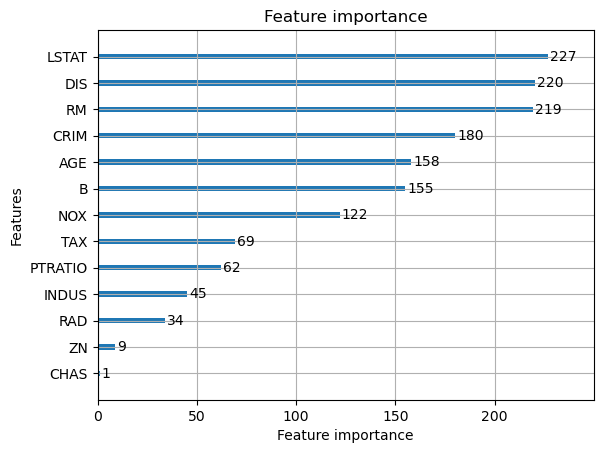

In [23]:
lgb.plot_importance(models[0][0])
plt.show()

### SHAP値と各変数の散布図

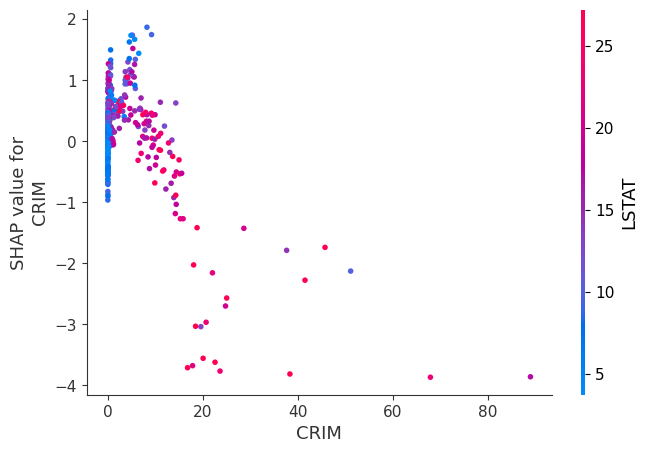

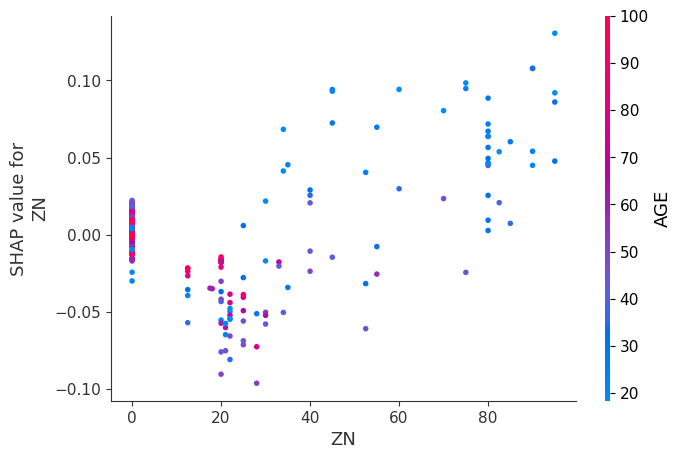

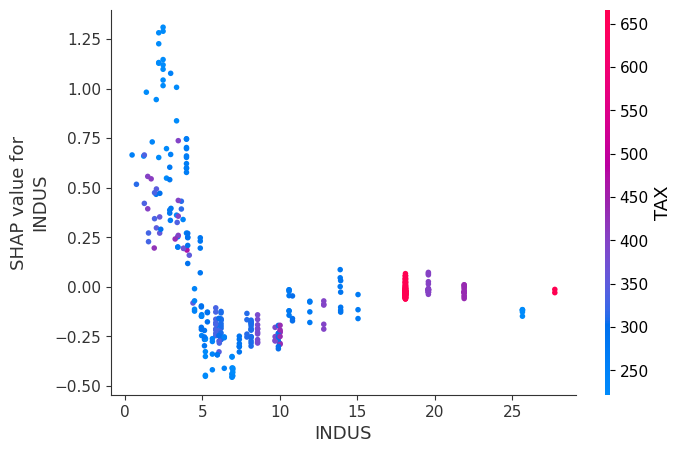

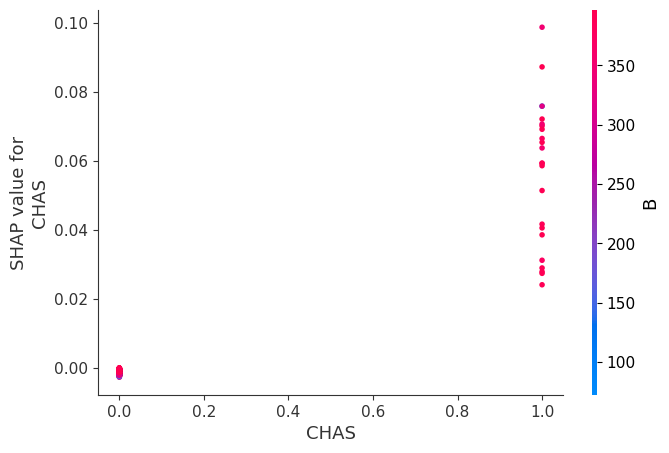

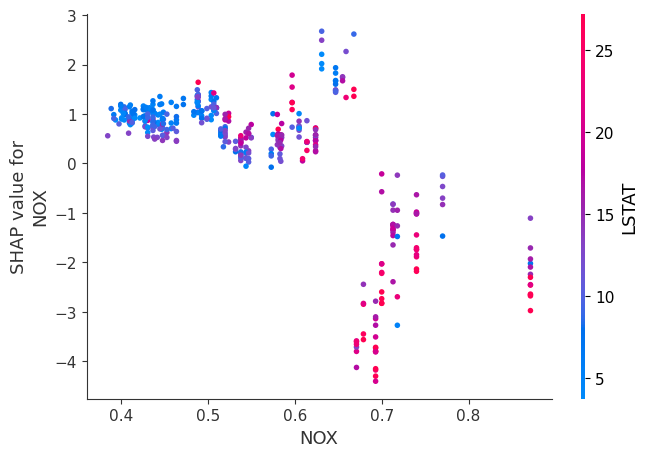

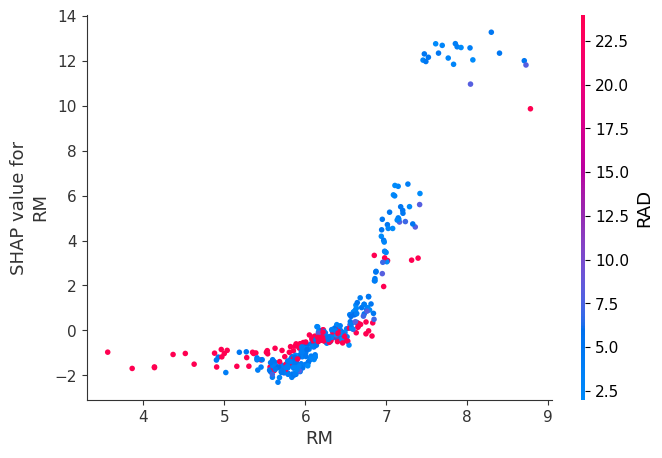

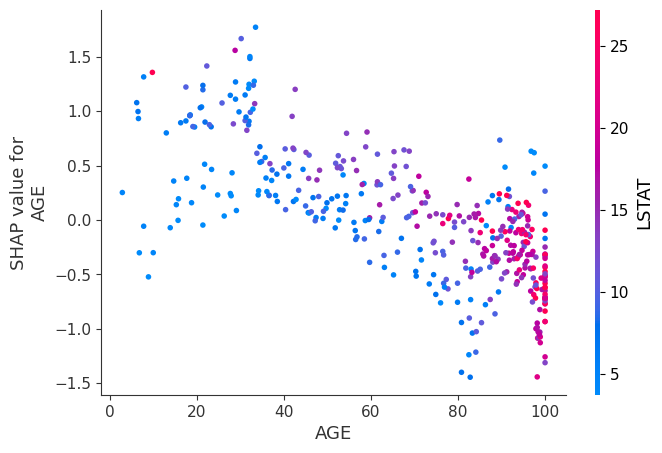

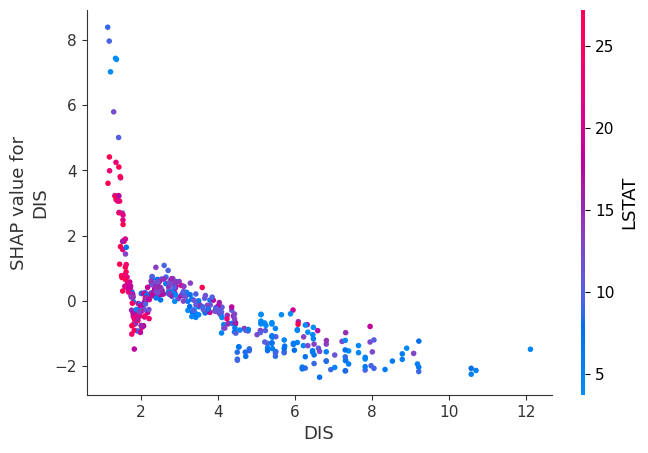

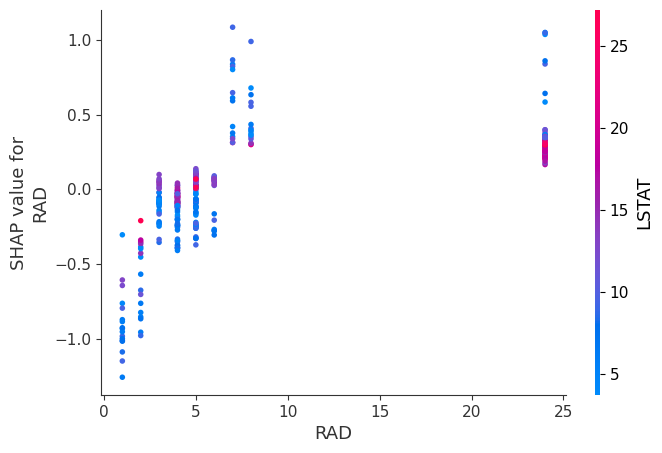

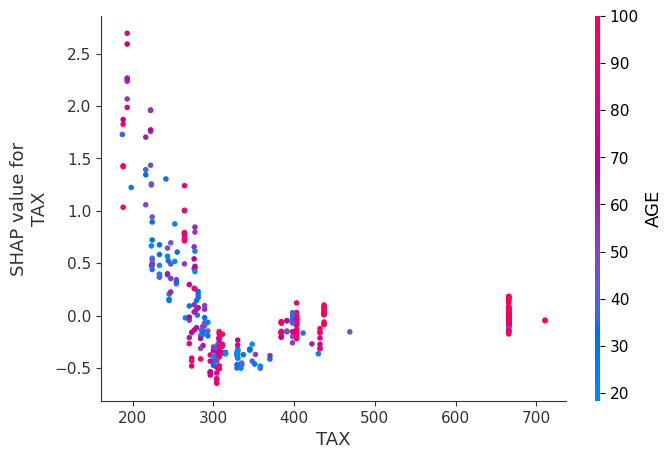

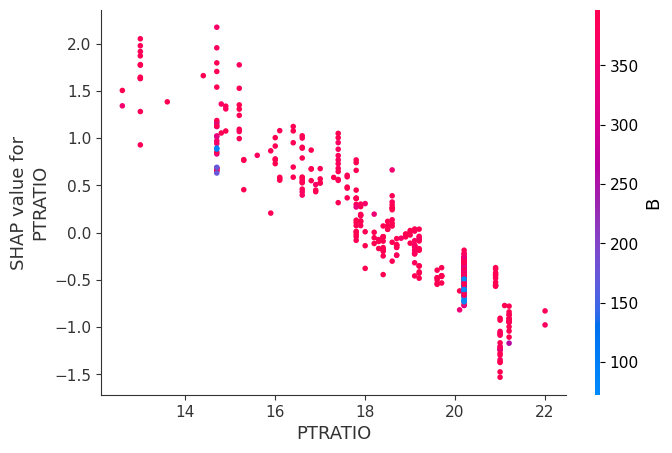

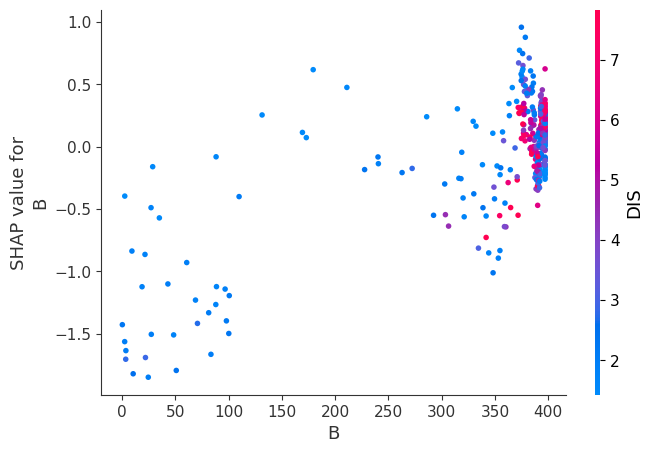

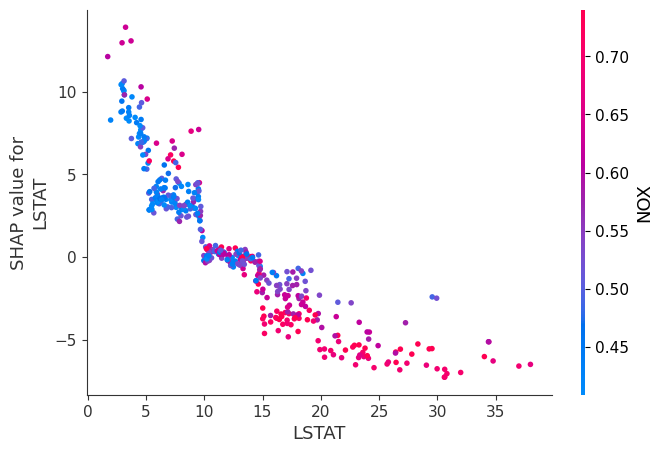

In [24]:
for col in x.columns:
    shap.dependence_plot(ind=col, shap_values=shap_values, features=x_train)

### SHAPの可視化
横軸がSHAPの値で縦軸に変数を置き色で各変数の値を表す。

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


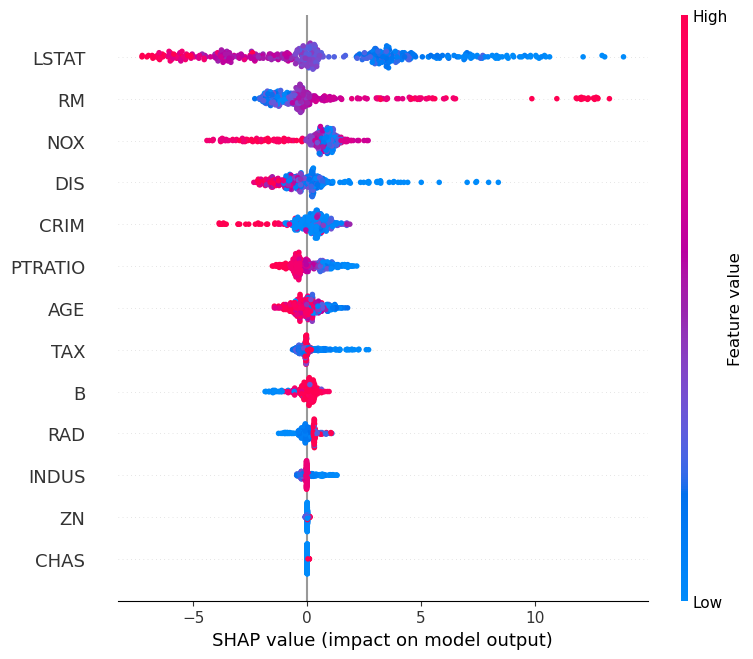

In [25]:
shap.summary_plot(shap_values,
                  x_train,
                  feature_names=x.columns)

### モデルの回帰の出力結果の過程

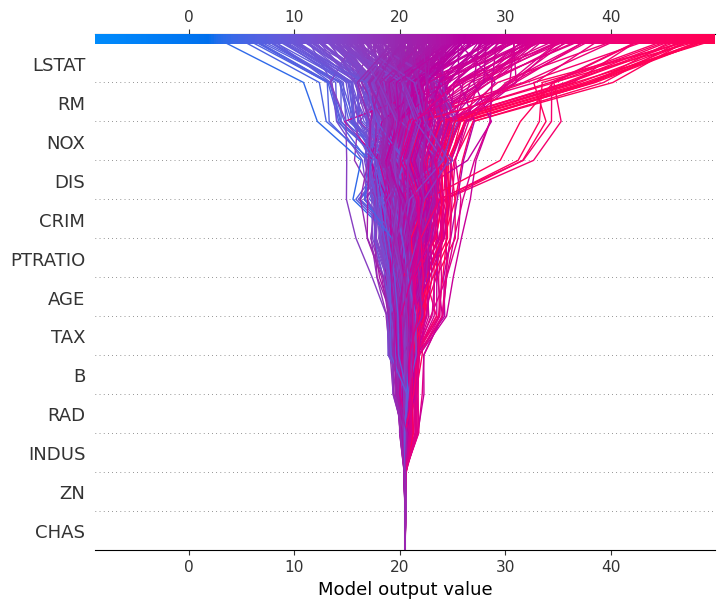

In [26]:
shap.decision_plot(explainer.expected_value, 
                   shap_values, 
                   x_train, 
                   x.columns.tolist())

この結果から出力結果の大小において途中でどのように折れ線グラフが変化しているかでどこか起因となっているかの傾向を考察する。